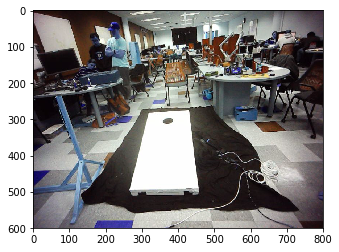

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
%matplotlib inline

# Load original source
img = cv.imread('newtestpics/te0.png')
orig = img.copy()
plt.imshow(img)

# Utility functions for dealing with contours
def get_cnt_details(cnt):
    M = cv.moments(cnt)
    details = None
    
    # if the moment is at point 00
    if (M['m00'] != 0):
        details = {}
        details['cx'] = cx = int(M['m10']/M['m00'])
        details['cy'] = cy = int(M['m01']/M['m00'])
        details['area'] = area = cv.contourArea(cnt)
        details['perimeter'] = perimeter = cv.arcLength(cnt,True)
        
        approx = cv.approxPolyDP(cnt,0.01*cv.arcLength(cnt,True),True)
        details['num_vertices'] = len(approx)
    else:
        return None

    if (details['area'] < 16):
        return None
    else:
        return details

def print_cnt_details(cnt):
    cnt_dict = get_cnt_details(cnt)
    
    if (cnt_dict is None):
        return
    
    cx = cnt_dict['cx']
    cy = cnt_dict['cy']
    area = cnt_dict['area']
    perimeter = cnt_dict['perimeter']
    num_vertices = cnt_dict['num_vertices']
    
    print('cx: ', cx, '\tcy: ', cy, '\tarea: ', area, '\tperimeter: ', perimeter, '\tvertices: ', num_vertices)

def cnt_is_circular(cnt):
    cnt_det = get_cnt_details(cnt)
    if (cnt_det is None):
        return False
    area = cnt_det['area']
    perimeter = cnt_det['perimeter']
    num_vertices = cnt_det['num_vertices']
    return True if (num_vertices < 15 and num_vertices > 4) else False

def cnt_is_board(cnt):
    cnt_det = get_cnt_details(cnt)
    if (cnt_det is None):
        return False
    area = cnt_det['area']
    num_vertices = cnt_det['num_vertices']
    approx = cv.approxPolyDP(cnt,0.01*cv.arcLength(cnt,True),True)
    return True if (area > 20000) else False


In [2]:
# Crop the image so we only observe the bottom half when finding contours
height, width, channels = img.shape
print('original_img\nheight: ', height, '\twidth: ', width, '\tchannels: ', channels)
# crop = img[0:width, 200:height]

original_img
height:  600 	width:  800 	channels:  3


cx:  414 	cy:  572 	area:  20734.5 	perimeter:  1257.0853482484818 	vertices:  11
cx:  567 	cy:  485 	area:  60.0 	perimeter:  106.28427076339722 	vertices:  8
cx:  526 	cy:  396 	area:  16.0 	perimeter:  59.455843687057495 	vertices:  13
cx:  366 	cy:  402 	area:  34530.5 	perimeter:  875.2030984163284 	vertices:  5
cx:  378 	cy:  502 	area:  76.0 	perimeter:  67.31370830535889 	vertices:  10
cx:  352 	cy:  502 	area:  37.0 	perimeter:  30.485281229019165 	vertices:  6
cx:  449 	cy:  502 	area:  22.0 	perimeter:  21.313708305358887 	vertices:  12
cx:  431 	cy:  491 	area:  22.0 	perimeter:  25.656854152679443 	vertices:  6
cx:  372 	cy:  304 	area:  379.0 	perimeter:  76.76955199241638 	vertices:  11
cx:  348 	cy:  252 	area:  307.5 	perimeter:  92.04163014888763 	vertices:  11


Text(0.5, 1.0, 'Cropped With Board/Circle Contours')

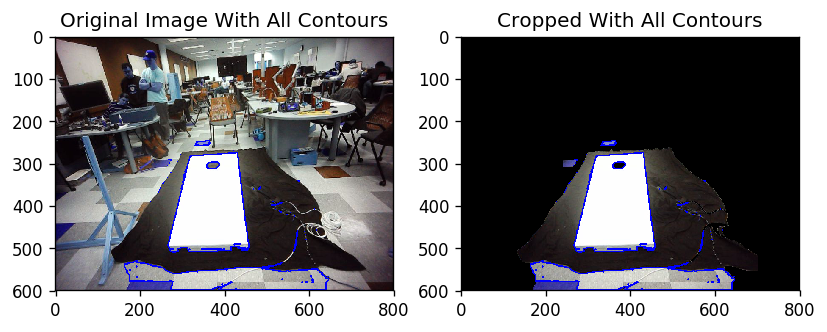

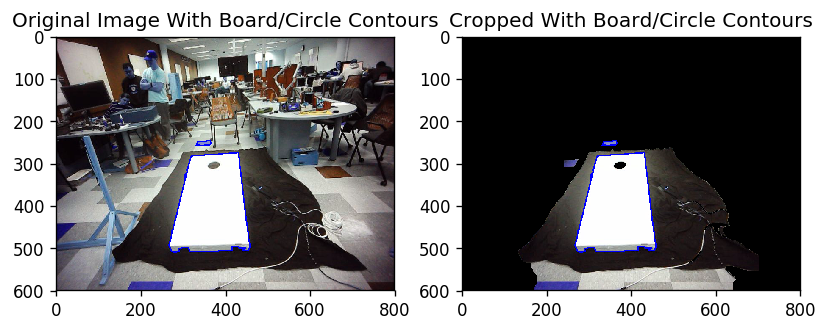

In [3]:
# Do algorithm grabCut(...) to separate foreground from background
mask = np.zeros(img.shape[:2], np.uint8)

bgdModel = np.zeros((1,65), np.float64)
fgdModel = np.zeros((1,65), np.float64)

#rect = (100,100, 450,500) # y1x1,y2x2
rect = (100,200,height,width)
cv.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv.GC_INIT_WITH_RECT)

mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]

# threshold binarily
#ret,thresh = cv.threshold(img,127,255,cv.THRESH_BINARY)

# find contours
graysrc = cv.cvtColor(img.copy(), cv.COLOR_BGR2GRAY)
ret,thresh = cv.threshold(graysrc, 127,255,0)
im2, contours, hierarchy = cv.findContours(thresh,cv.RETR_TREE, 1)

# Get board contour and potential hole contours
board_cnt = None
hole_cnt = None
for cnt in contours:
        
    print_cnt_details(cnt)
    if (cnt_is_circular(cnt)):
        hole_cnt = cnt
    if (cnt_is_board(cnt)):
        board_cnt = cnt

orig_w_cnts = cv.drawContours(orig.copy(), contours, -1, (0,0,255), 2)
crop_w_cnts = cv.drawContours(img.copy(), contours, -1, (0,0,255), 2)

# Plot original image with ALL contours
fig = plt.figure(figsize=(8,8),dpi=(120))
a = fig.add_subplot(1,2,1)
plt.imshow(orig_w_cnts)
a.set_title('Original Image With All Contours')
a = fig.add_subplot(1,2,2)
plt.imshow(crop_w_cnts)
a.set_title('Cropped With All Contours')

# Show ONLY supposed board and circle contours
cnts = [x for x in [hole_cnt, board_cnt] if x is not None]
orig_w_cnts = cv.drawContours(orig.copy(), cnts, -1, (0,0,255), 2)
crop_w_cnts = cv.drawContours(img.copy(), cnts, -1, (0,0,255), 2)

fig = plt.figure(figsize=(8,8),dpi=(120))
a = fig.add_subplot(1,2,1)
plt.imshow(orig_w_cnts)
a.set_title('Original Image With Board/Circle Contours')
a = fig.add_subplot(1,2,2)
plt.imshow(crop_w_cnts)
a.set_title('Cropped With Board/Circle Contours')


cx:  366 	cy:  402 	area:  34530.5 	perimeter:  875.2030984163284 	vertices:  5
cx:  348 	cy:  252 	area:  307.5 	perimeter:  92.04163014888763 	vertices:  11


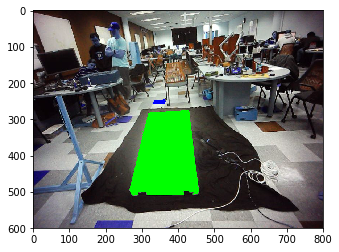

In [4]:

if (board_cnt is not None and hole_cnt is not None):
    img_board_circle_filled = cv.drawContours(orig.copy(), [board_cnt], 0, (0,255,0), cv.FILLED)
    print_cnt_details(board_cnt)
    cv.drawContours(img_board_circle_filled, [hole_cnt], 0, (0,0,255), cv.FILLED)
    print_cnt_details(hole_cnt)
    plt.imshow(img_board_circle_filled)
else:
    print("board_cnt or hole_cnt null")
    print("board contour: "), print_cnt_details(board_cnt)
    print("hole contour: "), print_cnt_details(hole_cnt)

"\nfig = plt.figure(figsize=(8,8),dpi=(120))\na = fig.add_subplot(2,2,2)\nplt.imshow(roi_with_hole)\na.set_title('Isolated Cornhole Board Region With Hole Isolated')\n"

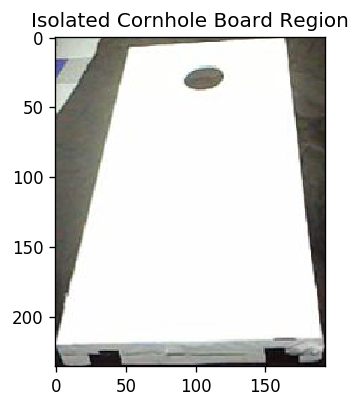

In [5]:
mask = np.zeros(img.shape, np.uint8)
cv.drawContours(mask, [board_cnt], 0, (255,255,255), cv.FILLED)

# Isolate the board area
x,y,w,h = cv.boundingRect(board_cnt)
roi = orig[y:y+h,x:x+w]

fig = plt.figure(figsize=(8,8),dpi=(120))
a = fig.add_subplot(2,2,1)
plt.imshow(roi)
a.set_title('Isolated Cornhole Board Region')

# Find the hole contour
graysrc = cv.cvtColor(roi.copy(), cv.COLOR_BGR2GRAY)
ret,thresh = cv.threshold(graysrc, 127,255,0)
im2, contours, hierarchy = cv.findContours(thresh,cv.RETR_TREE, 1)

# hole_cnt = [x for x in contours if cnt_is_circular(x)]
# print_cnt_details(hole_cnt)
# roi_with_hole = cv.drawContours(orig.copy(), [hole_cnt], 0, (0,255,0), cv.FILLED)
"""
fig = plt.figure(figsize=(8,8),dpi=(120))
a = fig.add_subplot(2,2,2)
plt.imshow(roi_with_hole)
a.set_title('Isolated Cornhole Board Region With Hole Isolated')
"""

cx:  372 	cy:  305 	area:  344.5 	perimeter:  76.18376553058624 	vertices:  8


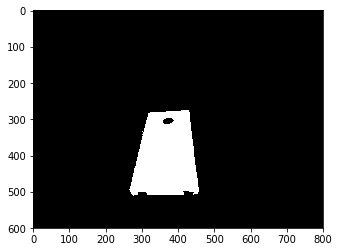

In [9]:
# The purpose of this block is to...
#    Create a mask of the board
#    Extract the board area to find the hole contour
#    Create a mask that doesn't include the hole contour

mask = np.zeros(orig.shape, np.uint8)
cv.drawContours(mask, [board_cnt], 0, (255,255,255), cv.FILLED) # draw the contour of the board in the empty mask

# find contours within board
board_only = np.zeros(orig.shape, np.uint8)
board_only[mask == 255] = orig[mask == 255]
graysrc = cv.cvtColor(board_only, cv.COLOR_BGR2GRAY)
ret,thresh = cv.threshold(graysrc, 127,255,0)
im2, contours, hierarchy = cv.findContours(thresh,cv.RETR_TREE, 1)


# find the one that's the hole
hole_cnt = None
largest_area = -np.inf
board_dets = get_cnt_details(board_cnt)
board_area = board_dets['area']
for cnt in contours:
    dets = get_cnt_details(cnt)
    if (dets is None):
        continue
    if (dets['area'] > largest_area and dets['area'] != board_area):
        hole_cnt = cnt


if (hole_cnt is not None):
    cv.drawContours(mask, [hole_cnt], 0, (0,0,0), cv.FILLED)
    print_cnt_details(hole_cnt)

#out = np.zeros(orig.shape, np.uint8)
#out = board_only.copy()
#out[mask == 255] = orig[mask == 255]

plt.imshow(mask)

In [ ]:
# Find contours within cornhole board area
graysrc = cv.cvtColor(img.copy(), cv.COLOR_BGR2GRAY)
ret,thresh = cv.threshold(graysrc, 127,255,0)
im2, contours, hierarchy = cv.findContours(thresh,cv.RETR_TREE, 1)


In [ ]:
img_w_bag = cv.imread('newtestpics/tr1.png')

#cv.bitwise_and(img_w_bag,img_w_bag,mask = mask)

plt.imshow(img_w_bag)